In [8]:
# preparation
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
%matplotlib inline

from prml.preprocess import GaussianFeature, PolynomialFeature, SigmoidalFeature
from prml.linear import (
    BayesianRegression,
    EmpiricalBayesRegression,
    LinearRegression,
    RidgeRegression
)

np.random.seed(1234)

def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    np.random.shuffle(x)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

之前说的是无监督学习：密度估计+聚类。这里讨论监督学习：回归。

回归就是D维变量对应目标变量t的问题。第一章有多项式曲线拟合。最简单就是线性回归。但如果将输入变量进行非线性函数变化后进行线性组合，可以的到基函数。

过程就是有N个观测量$ {x_n}, n = 1,...,N $和对应目标变量$ {t_n} $的训练数据集。目标有新的x预测新的t。就构建函数y(x)来预测输出。从概率角度看就是对每个x的目标t值的不确定性$ p(t|x) $进行建模。最小化一个合适的损失函数，比如1.5.5节中的平方损失函数。

虽然线性模型有局限性，但对于高维输入问题，比较好分析，是讨论的基础。

## 3.1线性基函数模型
最简单的回归线性模型是输入变量的线性组合：

$$ y(x,w) = w_0 + w_1x_1+ ... + w_Dx_D \tag{3.1} $$

其中$ x = (x_1,...,x_D)^T$。这通常被简单的叫做线性回归（linear regression）。这个模型的关键性属性是它是参数$ w_0,...,w_D $的一个线性函数。同时，它也是输入变量$ x_i $的一个线性函数，这给模型带来的极大的局限性。因此，我们将输入变量确定了的**非线性函数**进行线性组合来扩展模型的类别：

$$ y(x,w) = w_0 + \sum\limits_{j=1}^{M-1}w_j\phi_j(x) \tag{3.2} $$

其中$ \phi_j(x) $被称为基函数（basis function）。通过把下标$ j $的最大值记作$ M − 1$，使得这个模型中的参数总数为$ M $。

参数$w_0 $使得数据中可以存在任意的固定偏移，通常被称为偏置参数（bias parameter）（不要和统计观念下的“偏差”搞混淆：估计量的期望值与估计参数的真值之差。）。通常，定义一个额外的占位“基函数”$ \phi_0(x) = 1 $是很方便的，以便把函数简化为：

$$ y(x,w) = \sum\limits_{j=0}^{M-1}w_j\phi_j(x) = w^T\phi(x) \tag{3.3} $$

其中$ w = (w_0,...,w_{M-1})^T , \phi = (\phi_0,...,\phi_{M-1})^T $。

在很多模式识别的实际应用中，会在原始数据上进行预处理或特征抽取。


用非线性的基函数，我们允许函数$ y(x,w) $是**关于输入向量$ x $的非线性函数。由于式（3.2）是关于$ w $的线性函数，所以它被称为线性模型**。这种参数的线性性质极大地简化了这类模型的分析。不过，这也造成了3.6节所讨论的巨大的局限性。

第一章多项式拟合就是一个特例。基函数是x的幂指数$ \phi_j(x) = x^j $。

多项式基函数的一个局限性是它们是输入变量的全局函数，所以一个区域内个改变会影响所有区域。解决这个问题的方法是：把输入空间切分成若干个区域，然后对于每个区域用不同的多项式函数拟合。这样的函数叫做样条函数（spline function）（Hastie et al., 2001）。

还有许多其他的基函数的选择，如：
$$
\phi_{j}(x)=\exp \left\{-\frac{\left(x-\mu_{j}\right)^{2}}{2 s^{2}}\right\}
\tag{3.4} $$

其中$ \mu_j $控制着基函数在输入空间中的位置，参数$ s $控制着基函数的空间大小。这些通常被称为“高斯”基函数，虽然它们不一定具有概率解释。特别的，因为这些基函数会与一个调节参数$ w_j $ 相乘,所以标准化系数是不重要的。

另一种选择是sigmoid基函数：

$$ \phi_j(x) = \sigma\left(\frac{x-\mu_j}{s}\right) \tag{3.5} $$

其中$ \sigma(a) $是logistic sigmoid函数，由

$$ \sigma_a = \frac{1}{1+exp(-a)} \tag{3.6} $$


等价的，我们可以使用“tanh”函数，因为它和logistic sigmoid函数的关系$ tanh(a) = 2\sigma(2a) − 1 $，所以logistic sigmoid函数的一般线性组合，等价于“tanh”函数的一般线性组合。图3.1展示了选择不同的基函数的情况。



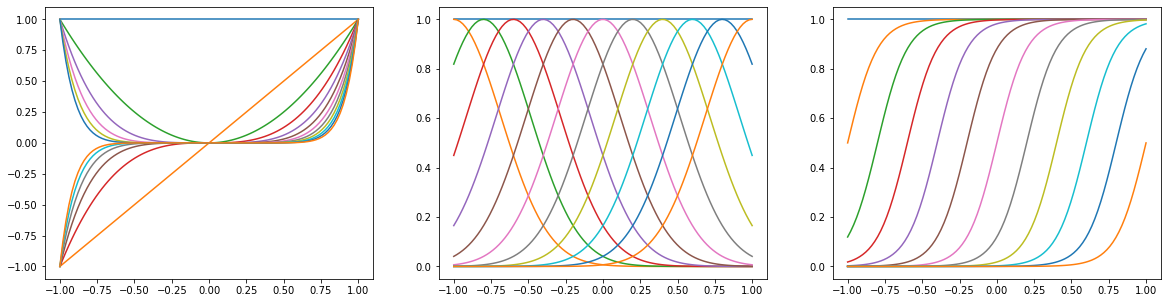

In [9]:
# 多项式 高斯基 sigmoid基函数
x = np.linspace(-1, 1, 100)
X_polynomial = PolynomialFeature(11).transform(x[:, None])
X_gaussian = GaussianFeature(np.linspace(-1, 1, 11), 0.1).transform(x)
X_sigmoidal = SigmoidalFeature(np.linspace(-1, 1, 11), 10).transform(x)

plt.figure(figsize=(20, 5))
for i, X in enumerate([X_polynomial, X_gaussian, X_sigmoidal]):
    plt.subplot(1, 3, i + 1)
    for j in range(12):
        plt.plot(x, X[:, j])

另一种可能的基函数选择是傅里叶基函数，它引出正弦函数展开。每个基函数表示一个具体的频率，并在空间中有无限的延伸。对比，限制在有限输入空间的不同的空间频率的频谱的基函数。在很多信号处理应用中，考虑同时在空间和频率受限的基函数是非常有趣的，这引出了一类被称为小波（wavelet）的函数。为了简化应用，这些基函数被定义成相互正交的。当输入值位于正规的格子框架中是，使用小波是最合适的。如在时间序列上的连续时间点，或图像中的像素。关于小波的有用的教程包括Ogden（1997），Mallat（1999）和Vidakovic（1999）。

本章中的大部分讨论都与基函数的选择无关，所以除非为了数值说明，我们大部分讨论不会指定基函数的具体形式。**事实上，我们的大部分讨论将会等同的使用基函数向量$ \phi(x) $的简单形式：$ \phi(x) = x $。还有，为了保持记号的简洁，我们把注意力集中在单目标变量$ t $的情形。但是在3.1.5节中，为了简要的说明必要的修改，我们处理多目标变量的情形。**

## 3.1.1最大似然和最小平方

第一章用多项式函数拟合数据(1.2.5节几乎一样的形式)。误差函数也可以看作高斯噪音下模型的最大似然的结果。开始更详细讨论。

同样假定目标变量$ t $是由确定函数$ y(x, w) $加上高斯噪声给出的：

$$ t = y(x,w) + \epsilon \tag{3.7} $$

其中$ \epsilon $是均值为0，精度（方差的逆）为$ \beta $的高斯随机变量。因此可以写成：

$$ p(t|x,w,\beta) = \mathcal{N}(t|y(x,w), \beta^{-1}) \tag{3.8} $$



回忆一下，如果假设一个平方损失函数，那么新的$ x $的值的最优的预测是由目标变量的条件均值给出。在式（3.8）的高斯条件分布下，得到条件均值（3.8中那个）：(参考1.89式)

$$ \mathbb{E}[t|x] = \int tp(t|x)dt = y(x,w) \tag{3.9} $$

注意，高斯噪声隐含$ x $上的$ t $的条件分布是单峰的，这可能不适用于某些应用。一个混合的条件高斯分布扩展，允许多峰条件分布，这我们将在14.5.1节中讨论。

现在，考虑输入$ X = {x_1,...,x_N} $和对应的目标值$ t_1,...,t_N $的数据集。把由目标向量$ {t_n} $组成列向量，记作$ \textbf{t} $。其中选择这个字体是为了与多元目标值的一次观测，记作$ t $做区分。假设这些数据是从分布（3.8）中独立的取出。那么，得到可调节参数$ w, \beta $的最大似然函数，形式为：
$$ p(\textbf{t}|\textbf{X,w},\beta) = \prod\limits_{n=1}^N\mathcal{N}(t_n|w^T\phi(x_n),\beta^{-1}) \tag{3.10} $$

其中使用了式（3.3）。注意，在监督学习问题如回归（或分类）中，我们不是为了寻找输入变量分布的模型。所以$ x $会一直出现在条件变量的位置，因此从现在开始，为了保持记号的简洁性，在诸如$ p(\textbf{t}|x,w,\beta) $这样的表达式中不显式地写出$ x $。取似然函数的对数，并使用一元高斯的标准形式（2.146），得到：

$$ \begin{eqnarray} \ln p(\textbf{t}|w, \beta) &=& \sum\limits_{n=1}^N \ln\mathcal{N}(t_n|w^T\phi(x_n),\beta^{-1}) \ &=& \frac{N}{2}\ln\beta-\frac{N}{2}\ln(2\pi) - \beta E_D(w) \tag{3.11} \end{eqnarray} $$


其中平方和误差函数定义为：

$$ E_D(w) = \frac{1}{2}\sum\limits_{n=1}^N\{t_n - w^T\phi(w_n)\}^2 \tag{3.12} $$

已经得到似然函数，我们可以通过最大似然的方法来确定$ w, \beta $。首先对于$ w $最大化。正如我们已经在1.2.5节中已经看到的那样，**我们看到在条件高斯噪声分布的情况下，线性模型的最大化似然 函数等价于最小化由$ E_D(w) $给出平方和误差函数**。式（3.11）给出的对数似然函数的梯度为：

$$ \nabla\ln p(\textbf{t}|w,\beta) = \sum\limits_{n=1}^N\{t_n - w^T\phi(x_n)\}\phi(x_n)^T \tag{3.13} $$

使这个梯度等于0，得到：

$$ 0 = \sum\limits_{n=1}^Nt_n\phi(x_n)^T - w^T\left(\sum\limits_{n=1}^N\phi(x_n)\phi(x_n)^T\right) \tag{3.14} $$

求解w，得到：

$$ w_{ML} = (\Phi^T\Phi)^{-1}\Phi^T\textbf{t} \tag{3.15} $$

这被称为最小二乘问题的正规方程组（normal equations）。其中$ \Phi $是被称为设计矩阵（design matrix）的一个$ N \times M $的矩阵，其中$ \Phi_{nj} = \phi_j(x_n) $，即

$$
\boldsymbol{\Phi}=\left(\begin{array}{cccc}
\phi_{0}\left(\boldsymbol{x}_{1}\right) & \phi_{1}\left(\boldsymbol{x}_{1}\right) & \cdots & \phi_{M-1}\left(\boldsymbol{x}_{1}\right) \\
\phi_{0}\left(\boldsymbol{x}_{2}\right) & \phi_{1}\left(\boldsymbol{x}_{2}\right) & \cdots & \phi_{M-1}\left(\boldsymbol{x}_{2}\right) \\
\vdots & \vdots & \ddots & \vdots \\
\phi_{0}\left(\boldsymbol{x}_{N}\right) & \phi_{1}\left(\boldsymbol{x}_{N}\right) & \cdots & \phi_{M-1}\left(\boldsymbol{x}_{N}\right)
\end{array}\right)
 \tag{3.16} $$

量

$$ \Phi^+ \equiv (\Phi^T\Phi)^{-1}\Phi^T \tag{3.17} $$

被称为矩阵$\Phi $的摩尔彭罗斯伪逆（Moore-Penrose pseudo-inverse）（Rao and Mitra, 1971; Golub and Van Loan, 1996）。它是逆矩阵概念在非方阵的推广。实际上，如果$ \Phi $是方阵且可逆，那么使用性质$ (AB)^{−1} = B^{−1}A^{−1} $，可以得到$ \Phi^+ \equiv \Phi^{−1} $。

现在，我们可以更加深刻地认识偏置参数$ w_0 $。如果显式地写出偏置参数，那么误差函数（3.12）变为：

$$
E_{D}(\boldsymbol{w})=\frac{1}{2} \sum_{n=1}^{N}\left\{t_{n}-w_{0}-\sum_{j=1}^{M-1} w_{j} \phi_{j}\left(\boldsymbol{x}_{n}\right)\right\}^{2}
\tag{3.18}
$$
对于$ w_0 $求导并使其等于0，求解$ w_0 $可得：

$$ w_0 = \bar{t} - \sum\limits_{j=1}^{M-1}w_j\bar{\phi}_j \tag{3.19} $$

其中定义了：
$$
\bar{t}=\frac{1}{N} \sum_{n=1}^{N} t_{n}, \quad \bar{\phi}_{j}=\frac{1}{N} \sum_{n=1}^{N} \phi_{j}\left(\boldsymbol{x}_{n}\right)
\tag{3.20} $$

因此偏置$ w_0 $补偿了目标值的均值(在训练集上的)与基函数的值的加权均值之间的差。

我们也可以对于噪声精度参数$ \beta $最大化对数似然函数（3.11），得到：

$$ \frac{1}{\beta_{ML}} = \frac{1}{N}\sum\limits_{n=1}^N\{t_n - w_{ML}^T\phi(x_n)\}^2 \tag{3.21} $$

因此，我们看到噪声精度的逆是由目标值在回归函数周围的残差的方差给出。

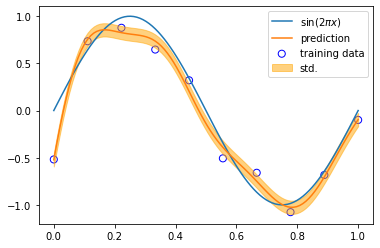

In [10]:
# 不同基函数拟合
def sinusoidal(x):
    return np.sin(2 * np.pi * x)

x_train, y_train = create_toy_data(sinusoidal, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = sinusoidal(x_test)

# Pick one of the three features below
#feature = PolynomialFeature(8)
#feature = GaussianFeature(np.linspace(0, 1, 8), 0.1)
feature = SigmoidalFeature(np.linspace(0, 1, 8), 10)

X_train = feature.transform(x_train)
X_test = feature.transform(x_test)
model = LinearRegression()
model.fit(X_train, y_train)
y, y_std = model.predict(X_test, return_std=True)

plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, label="$\sin(2\pi x)$")
plt.plot(x_test, y, label="prediction")
plt.fill_between(
    x_test, y - y_std, y + y_std,
    color="orange", alpha=0.5, label="std.")
plt.legend()
plt.show()

## 3.1.2 最小平方的几何描述
现在，考虑最小二乘方法的几何解释比较有指导意义。为了达到这个目的，考虑坐标轴由$ t_n $给出的$ N $维空间，$ \textbf{t} = (t_1,...,t_N)^T $是空间中的向量。通过$ N $个点估计出的每个基函数$ \phi_j(x_n) $也可以表示成相同空间中的一个向量，记作$ \varphi_j $，如图3.2展示。

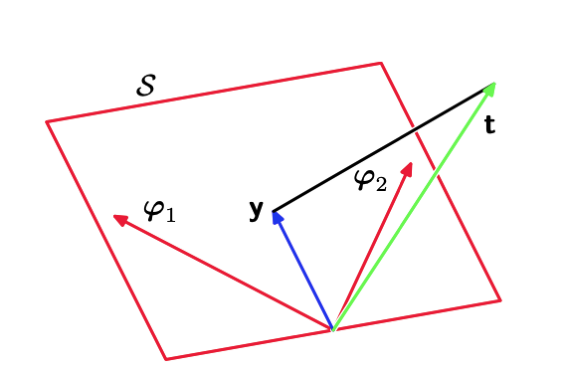

In [29]:
# 图3.2
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/3.1.2图3.2.png')
plt.axis('off')
ax.imshow(d)

注意$ \varphi_j $对应的是$\Phi $的第$ j $列，而$ \phi(x_n） $对应的是$ \Phi $的第$n $行。如果基函数的数量$ M $小于数据点的数量$ N $，那么$ M $个向量$ \phi_j(x_n) $可以生成$ M $维线性子空间$ S $。我们定义$ \textbf{y} $是$ N $维向量，其中第$ n^{th} $个元素由$ y(x_n,w) , n = 1,....,N $。由于$ \textbf{y} $是向量$ \varphi_j $的任意线性组合，所以它可以在$ M $维子空间的任意位置。平方和误差（3.12）等于$ \textbf{y, t} $之间的欧式距离（相差一个因子1/2）。所以$ w $的最小二乘解，对应子空间$ S $中与$ t $最近的$ \textbf{y} $的选择。直观地来说，从图3.2得到，我们预期这个解与$ t $在子空间$ S $上的投影正交。我们看到$ \textbf{y} $的解是由$ \Phi w_{ML} $给出的，然后可以很容易的证明它就是是正交投影的形式这一事实。


$$
\boldsymbol{\Phi}=\left(\begin{array}{cccc}
\phi_{0}\left(\boldsymbol{x}_{1}\right) & \phi_{1}\left(\boldsymbol{x}_{1}\right) & \cdots & \phi_{M-1}\left(\boldsymbol{x}_{1}\right) \\
\phi_{0}\left(\boldsymbol{x}_{2}\right) & \phi_{1}\left(\boldsymbol{x}_{2}\right) & \cdots & \phi_{M-1}\left(\boldsymbol{x}_{2}\right) \\
\vdots & \vdots & \ddots & \vdots \\
\phi_{0}\left(\boldsymbol{x}_{N}\right) & \phi_{1}\left(\boldsymbol{x}_{N}\right) & \cdots & \phi_{M-1}\left(\boldsymbol{x}_{N}\right)
\end{array}\right)
 \tag{3.16} $$

在实际应用中，当$ \Phi^T\Phi $接近奇异矩阵时，直接求解标准方程会导致数值计算上的困难。特别地，当两个或更多的基向量$ \varphi_j $共线或接近共线时，参数的结果会相当大。这样的退化在处理真实数据集的时候并不少见。这样的数值计算上的困难可以通过奇异值分解（singular value decomposition）简称SVD的方法来解决（Press et al., 1992; Bishop and Nabney, 2008）。注意，额外的正则项可以确保即使在退化的情况下，矩阵也是非奇异的（就是在求逆的时候多加了一项$\lambda I$，保证满秩和非奇异）。

## 3.1.3 顺序学习

像最大似然解（3.15）这样的涉及一次处理整个数据集的批量方法，对于大规模数据集来说计算量相当大。就像我们第1章中讨论的那样，当数据集相当大的时候，值得使用一种每次考虑一个数据点，然后更新模型参数的被称为在线算法的顺序算法。顺序学习同样适用于观测是顺序到达，并需要在所有数据到达前就做出预测的应用。
我们可以通过随机梯度下降（stochastic gradient descent）在后面也被称为顺序梯度下降（sequential grad ient descent）来得到顺序学习算法。如果误差函数由数据点的和$ E = \sum_nE_n $组成，那么在$ n $次这样的观测之后随机梯度算法使用
$ w^{(\tau+1)} = w^{(\tau)} - \eta\Delta E_n \tag{3.22} $
来更新参数向量$ w $。其中$ \tau $是迭代次数，$ \eta $是学习率参数。稍后会讨论$ \eta $的选择问题。$ w $被初始化为某个起始向量$ w^{(0)} $。在平方和误差函数（3.12）的情况下，得到：
$ w^{(\tau+1)} = w^{(\tau)} - \eta(t_n - w^{(\tau)T}\phi_n)\phi_n \tag{3.23} $
其中$ \phi_n = \phi(x_n) $。这就是最小均方（least-mean-squares）或LMS算法。需要小心的选择$ \eta $的值来确保算法收敛（Bishop and Nabney, 2008）。



## 3.1.4 正则化最小平方

在1.1节中，我们介绍了通过添加一个正则项来防止误差函数过拟的想法，得到的需要最小化的总误差函数的形式为：
$ E_D(w) + \lambda E_W(w) \tag{3.24} $
其中$ \lambda $是控制数据依赖误差$ E_D(w) $和正则项$ E_W(w) $的相对重要性的正则化参数。一个最简单的正则化项是加权向量元素的平方和：
$ E_W(w) = \frac{1}{2}w^Tw \tag{3.25} $
如果我们考虑由
$ E(w) = \frac{1}{2}\sum\limits_{n=1}^N\{t_n-w^T\phi(x_n)\}^2 \tag{3.26} $
给出的平方和误差函数，那么我们的总误差函数为：
$ \frac{1}{2}\sum\limits_{n=1}^N\{t_n-w^T\phi(x_n)\}^2 + \frac{\lambda}{2}w^Tw \tag{3.27} $
由于顺序学习算法，除非有数据支持，不然它倾向于让权值向零的方向衰减，所以这种正则项的选择在机器学习的文献中被称为权值衰减（weight decay）。在统计学中，由于它使参数向0收缩，所以它是参数收缩（parameter shrinkage）方法的一个例子。这种方法的优点是误差函数是$ w $的二次函数，因此精确的最小值有解析解。具体来说，令式（3.27）关于$ w $的梯度等于零，并求出$ w $，得到：
$ w = (\lambda I + \Phi^T\Phi)^{-1}\Phi^Tt \tag{3.28} $
这是最小二乘解（3.15）的一个简单扩展。
有时会使用一种正则化误差形式为
$ \frac{1}{2}\sum\limits_{n=1}^N\{t_n - w^T\phi(x_n)\}^2 + \frac{\lambda}{2}\sum\limits_{j=1}^M|w_j|^q \tag{3.29} $
的更加一般的正则化项。其中$ q=2 $对应二次正则项（3.27）。图3.3给出了不同$ q $值下的正则化函数的等高线。


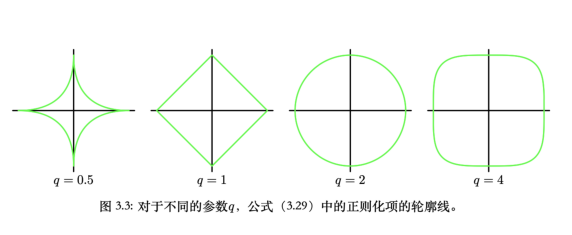

In [25]:
# 图3.3
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/3.1.4图3.3.png')
plt.axis('off')
ax.imshow(d)

图 3.3 不同$ q $值下的正则化函数
当$ q=1 $时，在统计文献中被称为lasso（Tibshirani, 1996）。它具有如果$ \lambda $充分大，那么某些系数$ w_j $会变为零，从而得到一个使得对应的基函数不起作用的稀疏模型。为了证明这点，首先注意到最小化式（3.29）等价于最小化满足限制
$ \sum\limits_{j=1}^M|w_j|^q \leq \eta \tag{3.30} $
的未正则化的平方和误差（3.12）。这样，这两种方法通过**拉格朗日乘数法**被联系到了一起。从图3.4可以知道稀疏性的来源：在限制条件（3.30）下误差函数的最小值。随着$ \lambda $的增大，越来越多的参数会变为零。

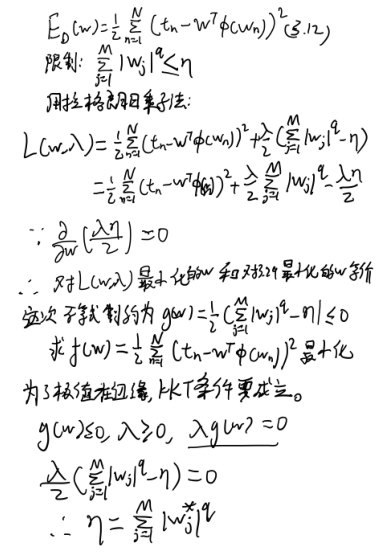

In [27]:
# 习题3.5
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/习题3.5.png')
plt.axis('off')
ax.imshow(d)

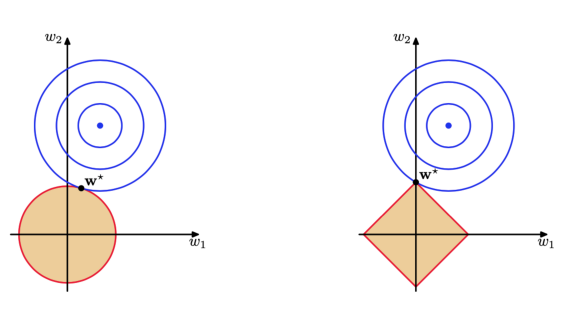

In [28]:
# 图3.4
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/3.1.4图3.4.png')
plt.axis('off')
ax.imshow(d)

图 3.4 lasso模型
正则化方法通过限制有效模型的复杂度，使得复杂的模型能够在有限大小的数据集上进行训练，而不产生严重的过拟合。然而，这就使确定最优的模型复杂度的问题从**确定合适的基函数的数量问题转移到了确定合适的正则化系数$ \lambda $的问题上**。在本章的后面还会回到这个模型复杂度的问题上。
对于本章的其余部分，主要讨论**二次正则化项（3.27）上**。




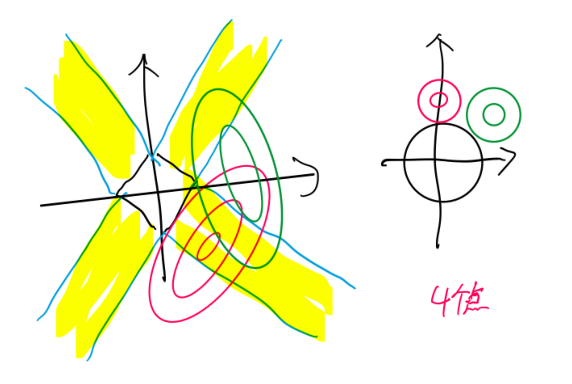

In [37]:
# 补充
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/3.1.4补充.png')
plt.axis('off')
ax.imshow(d)

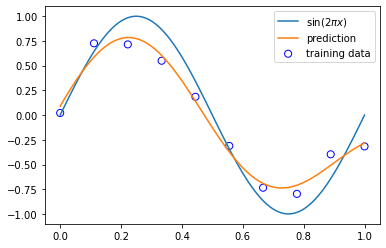

In [17]:
# 正则化
model = RidgeRegression(alpha=1e-3)
model.fit(X_train, y_train)
y = model.predict(X_test)

plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, label="$\sin(2\pi x)$")
plt.plot(x_test, y, label="prediction")
plt.legend()
plt.show()

## 3.1.5多个输出
目前为止，我们考虑的是单个目标变量$ t $的情况。在一些应用中，我们可能希望预测$ K > 1 $的多个目标变量，聚集起来，记作目标向量$ t $。这可以通过对于$ t $的每个分量，引入一个不同的基函数集合，从而变成了多个独立的回归问题。但是，一个更有趣的且更常用的方法是对目标向量的所有分量使用一组相同的基函数来建模，即
$ y(x,w) = W^T\phi(x) \tag{3.31} $
其中$ y $是$ K $维列向量，$ W $是$ M \times K $的参数矩阵，$ \phi(x) $是一个元素为$ \phi_j(x) $的$ M $维列向量，且与之前一样$ \phi_0(x) = 1 $。假设我们令目标向量的条件概率分布是一个形式为
$ p(t|x,W,\beta)=\mathcal{N}(t|W^T\phi(x),\beta^{-1}I) \tag{3.32} $
各向同性的高斯分布。如果有观测集合$ t_1,...,t_N $，那么可以把它们组合起来得到大小为$ N \times K $的矩阵$ T $，其中第$ n^{th} $行是$ t_n^T $。同样的，我们可以组合输入向量$ x_1,...,x_N $为矩阵$ X $。对数似然函数由
$ \begin{eqnarray} \ln p(T|X,W,\beta) &=& \sum\limits_{n=1}^N\ln\mathcal{N}(t_n|W^T\phi(x_n),\beta^{-1}I) \ &=& \frac{NK}{2}\ln\left(\frac{\beta}{2\pi}\right) - \frac{\beta}{2}\sum\limits_{n=1}^N\Vert t_n-W^T\phi(x_n) \Vert^2 \tag{3.33} \end{eqnarray} $
和之前一样，我们可以对这个函数关于$ W $求最大化，得到：
$ W_{ML} = (\Phi^T\Phi)^{-1}\Phi^TT \tag{3.34} $
如果对每个目标变量$ t_k $检验这个结果，得到：
$ w_k = (\Phi^T\Phi)^{-1}\Phi^Tt_k = \Phi^+t_k \tag{3.35} $
其中$ t_k $是分量为$ t_{nk}, n=1,...,N $的$ N $维列向量。所以得到的回归问题的解是根据不同目标变量分解开的，且只需要计算一次被所有向量$ w_k $共享的伪逆矩阵$ \Phi^+ $。

这可以直接的推广到具有任意协方差矩阵的一般的高斯噪声分布。**与之前一样，这个问题可以被分解为$ K $个独立的回归问题**。由于参数$ W $只定义了高斯噪声分布的均值，且从2.3.4节中得到多变量高斯的均值的最大似然解独立于协方差，所以这个结果是很显然的。从现在开始，为了简单起见，只考虑单目标变量$ t $的情况。



参考资料：
- http://prml.yutorihiro.com/chapter-3/3-5/
- https://www.slideshare.net/yasunoriozaki12/prml-29439402

## 3.2 偏置-方差分解
在目前讨论的线性回归模型中，我们假设**基函数的形式和数量**都已经确定的。
- 参数太多，容易过拟合。
- 参数太少，模型灵活性小。

参数多》引入正则化系数:
1. 系数大小又需要抉择。
2. 对于加权向量$ w $和正则化系数$ \lambda $求解最小化正则化误差函数，会得到$ \lambda = 0 $的非正则化的解，所以这显然不是正确的方法。(之前是$\lambda$是选定的时候求最小)

正如在之前章节看到的那样，过拟现象确实是最大似然的一个不好的性质，但是当我们在使用**贝叶斯方法对参数进行边缘化时它不会出现**。本章，我们会稍微深入的从贝叶斯观点讨论模型的复杂度。但是，**在开始讨论之前，从频率学家的偏置-方差权衡（bias-variance trade-off**观点来考虑一下模型的复杂度问题。

1.5.5节中，当我们讨论回归问题的决策论时，我们考虑了一旦我们知道了条件概率分布$ p(t|x) $，就能够给出对应的最优预测结果的不同损失函数。使用最多的平方误差函数，**此时最优预测的条件期望：**
$ h(x) = \mathbb{E}[t|x] = \int tp(t|x)dt \tag{3.36} $

复习1.5.5。
回到曲线拟合，计算平均损失，求期望。<p>
$$ \mathbb{E}[L] = \int\int L(t,y(x))p(x,t)dxdt \tag{1.86} $$<p>
平方误差：<p>
$$ \mathbb{E}[L] = \int\int\{y(x) - t\}^2p(x, t)dxdt \tag{1.87} $$<p>
变分法求解<p>
    $$ \frac{\delta\mathbb{E}[L]}{\delta y(x)} = 2\int \{y(x) - t\}p(x,t)dt = 0 \tag{1.88} $$<p>
整理：<p>
$$ y(x) = \frac{\int t p(x,t)dt}{p(x)} = \int t p(t|x)dt = \mathbb{E}_t[t|x] \tag{1.89} $$<p>
这就是回归函数：条件$ x $下$ t $的条件均值
另一种损失函数写法:<p>
    
平方项：    
$$ \begin{eqnarray} \{y(x) − t\}^2 &=& \{y(x) − E[t|x] + E[t|x] − t\}^2 \ &=& \{y(x) − E[t|x]\}^2 + 2\{y(x) − E[t|x]\}\{E[t|x] − t\} + \{E[t|x] − t\}^2 \end{eqnarray} $$<p>
    
    
损失函数：
$$ \mathbb{E}[L] = \int\{y(x) − E[t|x]\}^2p(x)dx + \int var[t|x]p(x)dx \tag{1.90} $$

第一项有y(x)，y(x)最优在条件均值的时候出现；第二项是t的方差在x上的平均，表明数据内在变化量，噪声，不可减小。

有必要区分一下**决策论中的平方损失函数$L(t,y(x))$以及模型参数的最大似然估计中的平方和误差函数**。我们可以使用比最小平方更复杂的方法，如正则化或纯粹的贝叶斯方法，来确定条件概率分布$ p(t|x) $。这些方法都可以与平方损失函数相结合来进行预测。

$E(\boldsymbol{w})=\frac{1}{2} \sum_{n=1}^{N}\left\{y\left(x_{n}, \boldsymbol{w}\right)-t_{n}\right\}^{2} \tag{1.2}$<p>

在1.5.5节中，我们证明了平方损失函数的期望可以写成(1.90)

$ \mathbb{E}[L] = \int \{y(x)-h(x)\}^2p(x)dx+\int\int\{h(x)-t\}^2p(x,t)dxdt \tag{3.37} $



第二项与y(x)无关，是数据本身噪声造成的，表示期望损失能达到的最小值。第一项于y(x)相关，因为非负的，最小是0.如果有无线数据和计算资源，可以找到任意精度的h(x),但实际数据有限为N个，不能精确找到h(x)。

如果使用由参数向量$ w $控制的参数函数$ y(x,w) $来对$ h(x) $建模，那么从贝叶斯的观点来看，模型的不确定性是通过$ w $的后验概率分布p(w|x)来表示的。**但频率学家用数据集D对w进行点估计，然后用下面的思想实验估计不确定性**。

假设有很多独立的从分布$ p(t,x) $中抽取的大小为$ N $的数据集。对于任意给定的数据集$ D $，可以运行我们的学习算法，得到一个预测函数$ y(x;D) $。不同的数据集会得出不同的函数，从而得出不同的平方损失。具体是学习算法表现是通过它在这些数据集上表现的平均值来评估的。
考虑式（3.37）的第一项的被积函数，对于一个特定的数据集$ D $，它的形式为：
$ \{y(x;D)−h(x)\}^2 \tag{3.38} $
因为这个项是依赖于具体的数据集$ D $，所以对所有的数据集求期望。如果在花括号中加上和减掉量$ \mathbb{E}_D[y(x;D)] $，展开得到：
$$
\begin{array}{c}
\left\{y(\boldsymbol{x} ; \mathcal{D})-\mathbb{E}_{\mathcal{D}}[y(\boldsymbol{x} ; \mathcal{D})]+\mathbb{E}_{\mathcal{D}}[y(\boldsymbol{x} ; \mathcal{D})]-h(\boldsymbol{x})\right\}^{2} \\
=\left\{y(\boldsymbol{x} ; \mathcal{D})-\mathbb{E}_{\mathcal{D}}[y(\boldsymbol{x} ; \mathcal{D})]\right\}^{2}+\left\{\mathbb{E}_{\mathcal{D}}[y(\boldsymbol{x} ; \mathcal{D})]-h(\boldsymbol{x})\right\}^{2} \\
\quad+2\left\{y(\boldsymbol{x} ; \mathcal{D})-\mathbb{E}_{\mathcal{D}}[y(\boldsymbol{x} ; \mathcal{D})]\right\}\left\{\mathbb{E}_{\mathcal{D}}[y(\boldsymbol{x} ; \mathcal{D})]-h(\boldsymbol{x})\right\}
\end{array}
 \tag{3.39}$$
现在关于$ D $求期望，然后注意到最后一项等于零，可得：
$$
\begin{array}{l}
\mathbb{E}_{\mathcal{D}}\left[\{y(\boldsymbol{x} ; \mathcal{D})-h(\boldsymbol{x})\}^{2}\right] \\
=\underbrace{\left\{\mathbb{E}_{\mathcal{D}}[y(\boldsymbol{x} ; \mathcal{D})]-h(\boldsymbol{x})\right\}^{2}}_{(\text {偏置 })^{2}}+\underbrace{\mathbb{E}_{\mathcal{D}}\left[\left\{y(\boldsymbol{x} ; \mathcal{D})-\mathbb{E}_{\mathcal{D}}[y(\boldsymbol{x} ; \mathcal{D})]\right\}^{2}\right]}_{\text {方差 }}
\end{array} \tag{3.40}
$$
我们看到，$ y(x;D) $与回归函数$ h(x) $的差的平方的期望可以表示为两项的和。**第一项被称为偏置（bias）的平方，表示所有数据集的平均预测与预期的回归函数之间的差异。第二项被称为方差（variance），度量了对于单独的数据集，模型所给出的解在它们的均值附近波动的情况，因此也就度量了函数$ y(x; D) $对于数据集的具体选择的敏感程度。**稍后我们会通过一个简单的例子，来直观地说明这些概念。


目前为止，我们已经考虑了单一输入变量$ x $的情形。如果把这个展开式带回式（3.37）中，那么我们就得到
$ \text{expected loss} = (\text{bias})^2 + \text{variance} + \text{noise} \tag{3.41} $
对于期望平方损失的分解。其中
$$
\begin{array}{c}
\text { 偏置 }^{2}=\int\left\{\mathbb{E}_{\mathcal{D}}[y(\boldsymbol{x} ; \mathcal{D})]-h(\boldsymbol{x})\right\}^{2} p(\boldsymbol{x}) \mathrm{d} \boldsymbol{x} \\
\text { 方差 }=\int \mathbb{E}_{\mathcal{D}}\left[\left\{y(\boldsymbol{x} ; \mathcal{D})-\mathbb{E}_{\mathcal{D}}[y(\boldsymbol{x} ; \mathcal{D})]\right\}^{2}\right] p(\boldsymbol{x}) \mathrm{d} \boldsymbol{x} \\
\text { 噪声 }=\iint\{h(\boldsymbol{x})-t\}^{2} p(\boldsymbol{x}, t) \mathrm{d} \boldsymbol{x} \mathrm{d} t
\end{array}
\tag{3.42,3.43,3.44}
$$
现在，偏置和方差指的是积分后的量。


我们的目标是最小化被分解为偏置（平方）、方差和一个常数噪声项的和的损失期望。正如我们将看到的那样，非常灵活的模型偏置较小，方差较大，相对固定的模型偏置较大，方差较小，所以我们要在偏置和方差之间做一个权衡。有着最优预测能力的模型是在偏置和方差之间取得最优的平衡的模型。这可以通过第1章讨论过的正弦数据集来说明。我们产生了100个数据集合，每个集合都包含独立地从正弦曲线$ h(x) = \sin(2\pi x) $抽取的$ N=25 $个数据点，数据集的编号为$ l = 1,...,L , L = 100 $，且使用包含24个高斯基函数的模型，**通过最小化正则误差函数（3.27）来拟合每个数据集$ D^{(l)} $，得到预测函数$ y^{(l)}(x) $，如图3.5展示。**

$ \frac{1}{2}\sum\limits_{n=1}^N\{t_n-w^T\phi(x_n)\}^2 + \frac{\lambda}{2}w^Tw \tag{3.27} $

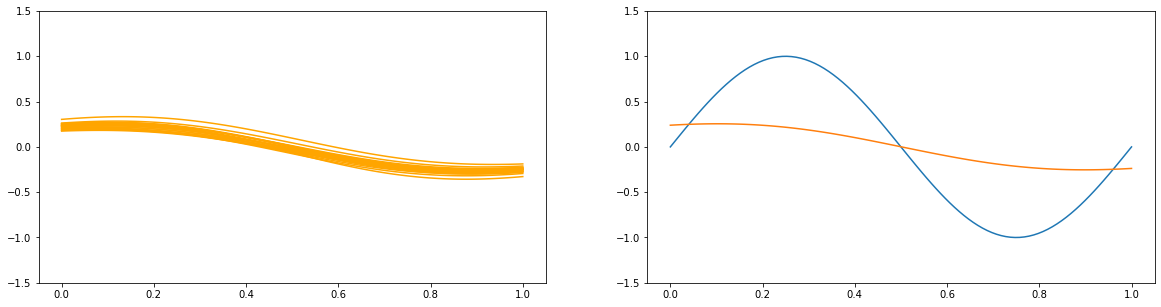

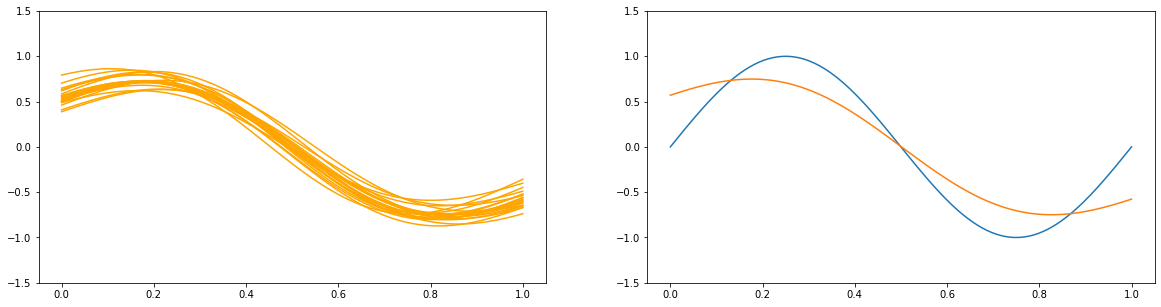

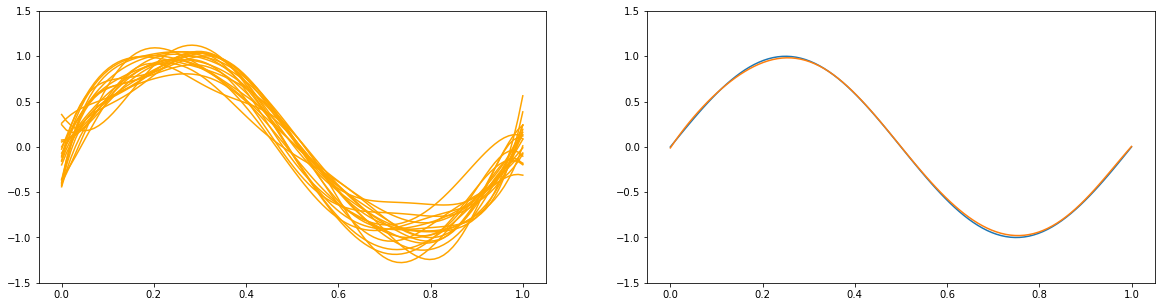

In [51]:
# 图3.5
#feature = PolynomialFeature(24)
feature = GaussianFeature(np.linspace(0, 1, 24), 0.1) # M
#feature = SigmoidalFeature(np.linspace(0, 1, 24), 10)

for a in [1e2, 1., 1e-9]:
    y_list = []
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    for i in range(100):
        x_train, y_train = create_toy_data(sinusoidal, 25, 0.25)# N
        X_train = feature.transform(x_train)
        X_test = feature.transform(x_test)
        model = BayesianRegression(alpha=a, beta=1.)
        model.fit(X_train, y_train)
        y = model.predict(X_test)
        y_list.append(y)
        if i < 20:
            plt.plot(x_test, y, c="orange")
    plt.ylim(-1.5, 1.5)
    
    plt.subplot(1, 2, 2)
    plt.plot(x_test, y_test)
    plt.plot(x_test, np.asarray(y_list).mean(axis=0))
    plt.ylim(-1.5, 1.5)
    plt.show()


最上面的一行对应着较大的正则化系数$ \lambda $，这样的模型的方差很小（因为左侧图中的红色曲线看起来很相似）,但是偏置很大（因为右侧图中的两条曲线看起来相当不同）。相反，最下面的一行，正则化系数$ \lambda $很小，这样模型的方差较大（因为左侧图中 的红色曲线变化性相当大），但是偏置很小（因为平均拟合的结果与原始正弦曲线十分吻合）。注意，把$ M = 25 $的这种复杂模型的多个解进行平均，会产生对于回归函数非常好的拟合，这表明求平均是一个很好的步骤。事实上，将多个解加权平均是贝叶斯方法的核心，虽然这种求平均针对的是参数的后验分布，而不是多个数据集。
我们也可以定量地检验这个例子的偏置-方差权衡。平均预测通过
$ \bar{y}(x) = \frac{1}{L}\sum\limits_{l=1}^Ly^{(l)}(x) \tag{3.45} $
估计得到。且积分后的偏置的平方及方差由
$ \begin{eqnarray} (\text{bias})^2 &=& \frac{1}{N}\sum\limits_{n=1}^N\{\bar{y}(x_n) - h(x_n)\}^2 \tag{3.46} \\ \text{variance} &=& \frac{1}{N}\sum\limits_{n=1}^N\frac{1}{L}\sum\limits_{l=1}^L\{y^{(l)}(x_n) - \bar{y}(x_n)\}^2 \tag{3.47} \end{eqnarray} $
其中由概率分布$ p(x) $加权的关于$ x $的积分由来自那个分布的有限数据点的和来近似的。图3.6展示了这些量以及它们的和关于$ \ln\lambda $的函数图像。

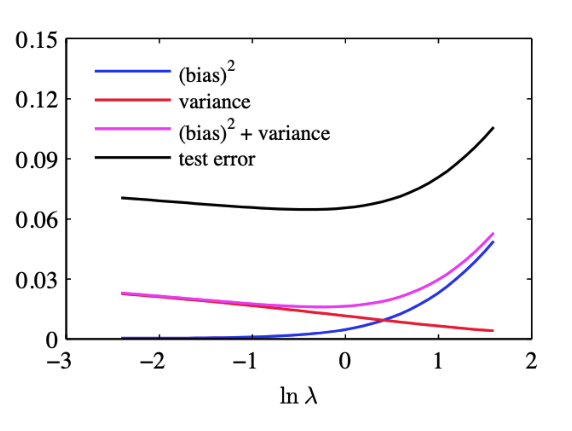

In [48]:
# 图3.6
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图3.6.png')
plt.axis('off')
ax.imshow(d)

我们看到，**小的$ \lambda $使得模型针对各个数据集里的噪声做了很好的调节，导致了较大的方差。相反，大的$ \lambda $把权值参数拉向零，导致了较大的偏置。**

虽然偏置-方差分解能够从频率论的角度对模型的复杂度提供一些有趣的见解，但是因为偏置-方差分解依赖于对所有的数据集的平均，而**实际应用中我们只有一个观测数据集**，所以它的实用价值很有限。如果我们有大量的给定大小的独立的训练数据集，那么**最好的方法是把它们组合成一个大的训练集，来降低给定复杂度的模型的过拟合程度。**
由于有这么多局限性，因此我们在下一节里将讨论线性基函数模型的贝叶斯观点。它不仅提供了对过拟现象的深刻见解，还提出了解决模型复杂度问题的实用的技术。



## 3.3 贝叶斯回归

从使用最大似然来确定线性回归模型的参数的讨论中，我们知道**控制模型的复杂度的基函数的数量，需要根据数据集的大小来确定**。向对数似然函数中添加正则项后，可以通过**正则系数来控制模型的复杂度，但基函数的数量和形式的选择也对于确定模型的整体行为十分重要**。

由于最大化似然函数通常会导致过度复杂的模型和过拟问题，所以我们不能简单的通过它来确定具体问题的**合适**的模型复杂度。如1.3节所说的那样，**独立的额外数据可以用来确定模型的复杂度，但是这需要较大的计算量，并且浪费了有价值的数据（验证集）**。因此，我们开始讨论既可以避免最大似然的过拟问题，也可以用训练数据本身自动的确定模型复杂度的线性回归的**贝叶斯方法**。与之前一样，为了简单起见，只考虑**单目标变量$t $的情形。对于多个目标变量情形与3.1.5节一样可以直接推广得到**。

## 3.3.1参数分布
我们以介绍模型参数$ w $的先验概率分布来开始我们的线性回归的贝叶斯方法讨论。这个阶段，我们把噪声精度参数$ \beta $当做已知常数。首先，注意到，式（3.10）定义的**似然函数$ p(t|w) $是$ w $的二次函数的指数形式**。于是对应的**共轭先验是形式为**
$ p(w) = \mathcal{N}(w|m_0,S_0) \tag{3.48} $
均值和方差分别为$ m_0, S_0 $的高斯分布。
最大似然函数，形式为：
$$ p(\textbf{t}|\textbf{X,w},\beta) = \prod\limits_{n=1}^N\mathcal{N}(t_n|w^T\phi(x_n),\beta^{-1}) \tag{3.10} $$



计算后验分布，类比直接写。由于在推导公式（2.116）时，已经进行了必要的工作，所以我们能够直接写出后验概率分布的形式：
$ p(w|t) = \mathcal{N}(w|m_N,S_N) \tag{3.49} $
其中
$$ \begin{eqnarray} m_N &=& S_N(S_0^{-1}m_0 + \beta\Phi^Tt) \tag{3.50} \\ S_N^{-1} &=& S_0^{-1} + \beta\Phi^T\Phi \tag{3.51} \end{eqnarray} $$

补充：

对于$ x $的边缘高斯分布和$ y $关于$ x $的条件高斯分布：

$$ p(x) = \mathcal{N}(x|\mu,\Lambda^{-1}) \tag{2.113} $$

$$ p(y|x) = \mathcal{N}(y|Ax + b,L^{-1}) \tag{2.114} $$

那么$ y $的边缘分布和$ x $关于$ y $的条件高斯分布为：

$$ p(y) = \mathcal{N}(y|A\mu + b,L^{-1} + A\Lambda^{-1}A^T) \tag{2.115} $$

$$ p(x|y) = \mathcal{N}(x|\Sigma\left\{A^TL(y-b) + \Lambda\mu \right\},\Sigma) \tag{2.116} $$

其中

$$ \Sigma = (\Lambda + A^TLA)^{-1} \tag{2.117} $$

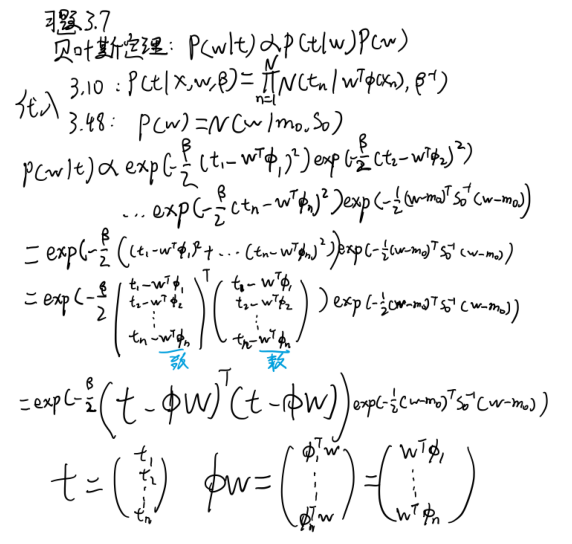

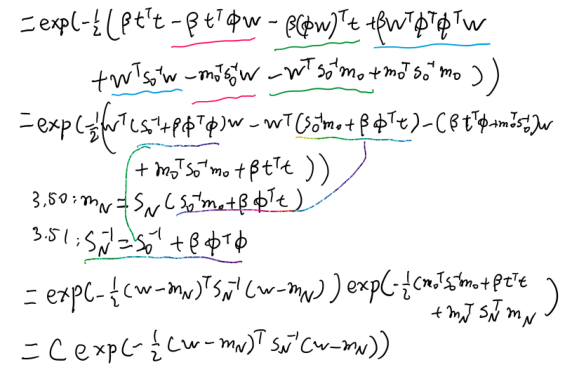

In [65]:
# 习题3.7
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/习题3.7up.png')
plt.axis('off')
ax.imshow(d)

fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/习题3.7down.png')
plt.axis('off')
ax.imshow(d)

注意，**由于后验分布是高斯的，它的众数（概率分布最高点）与均值正好相同。因此最大后验权向量由$ w_{MAP} = m_N $给出**。如果考虑一个无限宽的先验$ S_0 = \alpha^{−1}I $，其中$ \alpha \to 0 $，那么后验分布的均值$ m_N $就退化成了由式（3.15）给出的**最大似然值$ w_{ML} $(无信息先验)**。类似地，**如果$ N = 0 $，那么后验分布就被还原成先验分布**。此外，**如果数据点是顺序到达的，那么任何一个阶段的后验分布都可以看成后续数据点的先验分布。此时新的后验分布再次由式（3.49）给出**。

简化，有一个特定的形式高斯先验：一个只由一个精度参数$ \alpha $控制的零均值各向同性高斯分布：
$ p(w|\alpha) = \mathcal{N}(w|0,\alpha^{-1}I) \tag{3.52} $

且对应的关于$ w $的后验分布由式（3.49）给出，其中
$ \begin{eqnarray} m_N &=& \beta S_N\Phi^Tt \tag{3.53} \\ S_N^{-1} &=& \alpha I + \beta\Phi^T\Phi \tag{3.54} \end{eqnarray} $

后验分布的对数是由对数似然与先验的对数的和给出的一个关于$ w $的函数，形式为：
$ \ln p(w|t) = -\frac{\beta}{2}\sum\limits_{n=1}^N\{t_n - w^T\phi(x_n)\}^2 - \frac{\alpha}{2}w^Tw + const \tag{3.55} $
关于$ w $来最大化这个后验分布等价于最小化加上一个二次正则项的平方和误差函数，正则项对应$ \lambda = \alpha/\beta $的式（3.27）。



简化模型方便理解：考虑单输入变量$ x $，单目标变量$ t $和线性模型形式$ y(x,w) = w_0 + w_1x $。

我们从带有参数$ a_0 = -0.3, a_1 = 0.5 $的函数$ f(x,a) = a_0 + a_1x $中生成数据。生成方法是：首先从均匀分布$ U(x|-1,1) $中选择$ x_n $的值，再计算$ f(x_n,a) $，最后加上一个标准差为0.2的高斯噪声，得到目标变量$ t_n $。我们的目标是从这样的数据中恢复$ a_0,a_1 $的值,并探索模型对数据集规模的依赖关系。

这里我们假设噪声方差是已知的，所以我们把精度参数设置为它的真实值$ \beta = (1/0.2)^2 = 25 $。同样的，我们把$ \alpha $固定为$ 2.0 $。

图3.7展示了当数据集的规模增加时贝叶斯学习的结果，还展示了贝叶斯学习的顺序本质，即当新数据点被观测到的时候，当前的后验分布变成了先验分布。

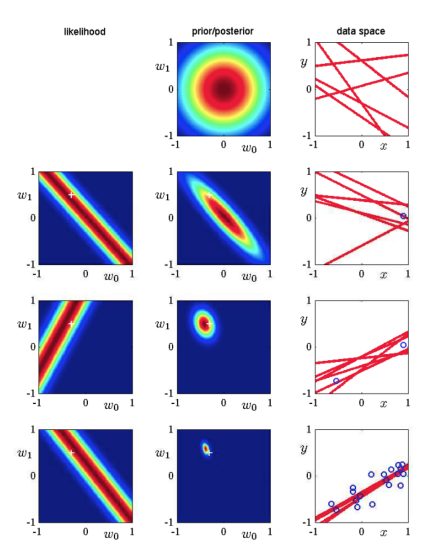

In [11]:
# 图3.7
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图3.7.png')
plt.axis('off')
ax.imshow(d)

花时间仔细研究一下这幅图是很值得的，因为它说明了贝叶斯推断的一些重要的概念。这幅图的第一行对应着，观测到数据之前，$ w $空间中先验分布的图像，以及六个$ w $从先验中获得的函数$ y(x, w) $。第二行展示了观测到一个数据点之后的情形。数据点的位置$ (x, t) $由右手边的列中的蓝色圆圈表示。左手边的列展示了这个数据点的似然函数$ p(t,w) $关于$ w $的函数图像。注意，**似然函数给出了直线必须穿过数据点附近的位置的软性限制，其中附近由噪声精度$ \beta $确定。**为了进行对比，用来生成数据集的真实参数值$ a_0 = −0.3,a_1 = 0.5$在图3.7的右手边的列以白色十字标记出来。我们用这个似然函数乘以从最上面一行得到的先验，然后标准化后得到的后验分布展示在第二行的中间。从这个后验分布得到的$ w $的样本对应的回归函数$ y(x,w) $展示在右手边。注意，这些直线样本都穿过数据点的附近。这幅图的第三行展示了观测到第二个点的效果，同样以蓝色圈展示在右手边的列中。对应这个数据点自身的似然函数展示在左边图像中。如果我们把这个似然函数与第二行的后验概率分布相乘，就得到了第三行中间一列的图展示的后验分布。注意，这个后验分布与我们将原始的先验分布结合两个数据点的似然函数得到的后验概率分布完全相同。**现在，后验概率分布被两个数据点影响。由于两个点足够定义一条直线，因此已经得到了相对紧凑的后验分布。**这个后验分布中的样本给出了第三列中红色的函数图像。我们看到这些函数同时穿过了两个数据点的附近。第四行展示了观测到全部20个数据点的效果。左侧的图展示了第20个数据点自身的似然函数，中间的图展示了吸收了全部20个测试信息所给出的后验分布。注意，这个后验比第三行的变得更加尖锐。在无穷多数据点的极限情况下，**后验概率分布会变成一个以真实参数值（以白色十字标记）为中心的Delta函数。**

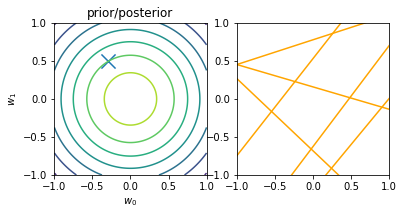

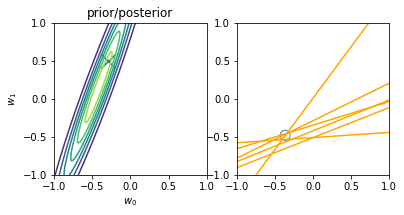

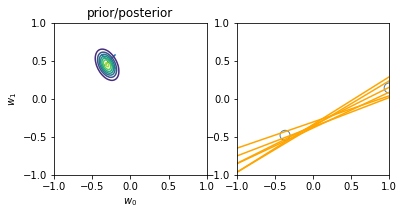

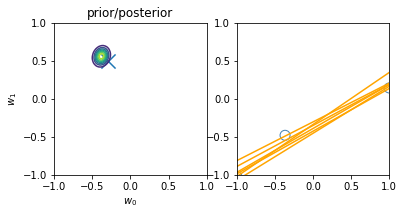

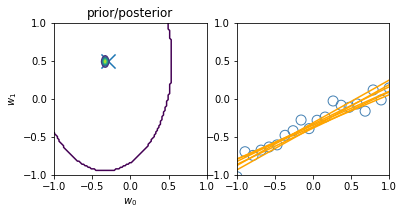

In [12]:
# 自定义图3.7
def linear(x):
    return -0.3 + 0.5 * x


x_train, y_train = create_toy_data(linear, 20, 0.1, [-1, 1])
x = np.linspace(-1, 1, 100)
w0, w1 = np.meshgrid(
    np.linspace(-1, 1, 100),
    np.linspace(-1, 1, 100))
w = np.array([w0, w1]).transpose(1, 2, 0)

feature = PolynomialFeature(degree=1)
X_train = feature.transform(x_train)
X = feature.transform(x)
model = BayesianRegression(alpha=1., beta=100.)

for begin, end in [[0, 0], [0, 1], [1, 2], [2, 3], [3, 20]]:
    model.fit(X_train[begin: end], y_train[begin: end])
    plt.subplot(1, 2, 1)
    plt.scatter(-0.3, 0.5, s=200, marker="x")
    plt.contour(w0, w1, multivariate_normal.pdf(w, mean=model.w_mean, cov=model.w_cov))
    plt.gca().set_aspect('equal')
    plt.xlabel("$w_0$")
    plt.ylabel("$w_1$")
    plt.title("prior/posterior")

    plt.subplot(1, 2, 2)
    plt.scatter(x_train[:end], y_train[:end], s=100, facecolor="none", edgecolor="steelblue", lw=1)
    plt.plot(x, model.predict(X, sample_size=6), c="orange")
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

**其他形式的参数先验也可以被考虑。**例如，我们可以推广高斯先验分布，得到：
$$
p(\boldsymbol{w} \mid \alpha)=\left[\frac{q}{2}\left(\frac{\alpha}{2}\right)^{\frac{1}{q}} \frac{1}{\Gamma\left(\frac{1}{q}\right)}\right]^{M} \exp \left(-\frac{\alpha}{2} \sum_{j=0}^{M-1}\left|w_{j}\right|^{q}\right)
\tag{3.56} $$
当$ q = 2 $时对应着高斯分布，并且只有在这种情形下的先验才与式（3.10）给出的似然函数共轭。找到$ w $的后验概率分布的最大值等价于找到正则化误差函数（3.29）的最小值。在高斯先验的情况下，后验概率分布的众数等于均值，但是当$ q \neq 2 $时这个性质就不成立了。

## 3.3.2 预测分布

在实际应用中，我们对新的$ x $的值**预测**出$ t $比$ w $的值本身更感兴趣。这需要我们估计出定义为
$ p(t|\textbf{t},\alpha,\beta) = \int p(t|w,\beta)p(w|\textbf{t},\alpha,\beta)dw \tag{3.57} $

的预测分布。其中$ \textbf{t} $是训练集中的目标向量，且为了简化记号，我们省略了右边条件表达式中的输入向量。目标变量的条件分布由式（3.8）给出，后验分布由式（3.49）给出。我们看到式（3.57）涉及两个高斯分布的卷积，所以使用8.1.4节中得到的式（2.115）的结果，得到的预测分布的形式为：

$ p(t|x,\textbf{t},\alpha,\beta) = \mathcal{N}(t|m_N^T\phi(x),\sigma_N^2(x)) \tag{3.58} $
其中预测分布的方差$ \sigma_N^2(x) $是
$ \sigma_N^2(x) = \frac{1}{\beta} + \phi(x)^TS_N\phi(x) \tag{3.59} $

补充：（个人认为符号混乱）

目标变量的条件分布：

$$ p(t|x,w,\beta) = \mathcal{N}(t|y(x,w), \beta^{-1}) \tag{3.8} $$

后验分布
$ p(w|t) = \mathcal{N}(w|m_N,S_N) \tag{3.49} $

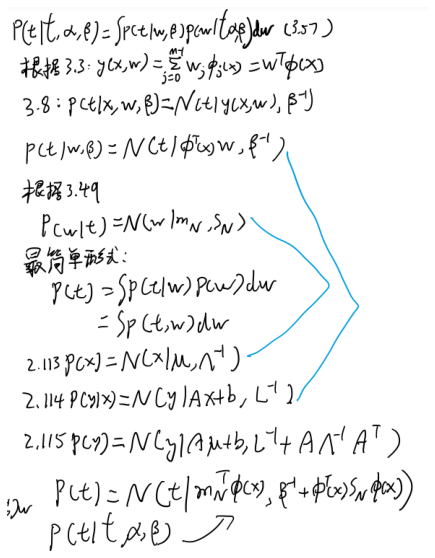

In [19]:
# 习题3.10
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/习题3.10.png')
plt.axis('off')
ax.imshow(d)

**（3.59）中的第一项表示数据上的噪声，而第二项反应了与参数$ w $关联的不确定性**。由于噪声的处理与$ w $的分布是相互独立的高斯，它们的方差是可加的。注意，当额外的数据点被观测到的时候，后验概率分布会变窄。从而可以证明$ \sigma_{N+1}^2(x) \leq \sigma_N^2(x) $（Qazaz et al., 1997）。在取极限$ N \to \infty $的情况下，式（3.59）的第二项趋向于0，这时预测分布的方差只来自于由参数$ \beta $控制的可加噪声。

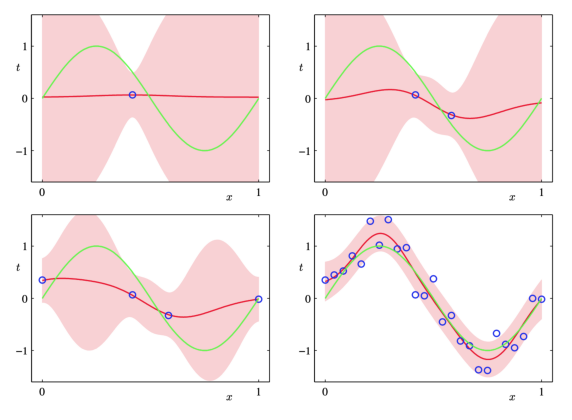

In [20]:
# 习题3.8
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图3.8.png')
plt.axis('off')
ax.imshow(d)

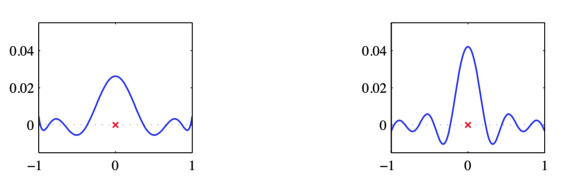

In [21]:
# 习题3.11
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图3.11.png')
plt.axis('off')
ax.imshow(d)

为了阐释贝叶斯线性回归模型的预测分布，让我们回到1.1节中人工生成的正弦数据集。在图3.8中，我们展示了在由高斯基函数线性组合成的模型下，不同数据集大小和对应的后验分布的关系。

其中，绿色曲线对应生成数据（加上高斯噪声）的函数$ \sin(2\pi x) $。大小为$ N=1, N=2, N=4, N=25 $的数据集以蓝色的圈展示在图中。每幅图中红色曲线展示了高斯预测分布的均值，红色阴影区域是均值两侧的一个标准差范围的区域。注意，预测的不确定性依赖于$ x $，且在数据点的邻域内最小。还有就是，不确定性的程度随着观测到的数据点的增多而逐渐减小。

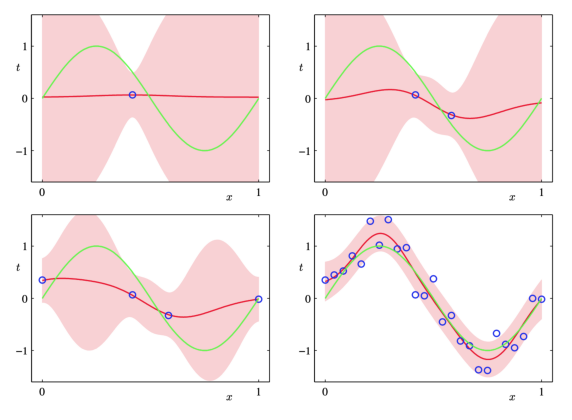

In [22]:
# 图3.8
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图3.8.png')
plt.axis('off')
ax.imshow(d)

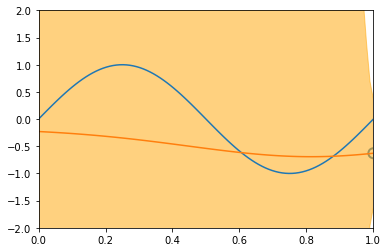

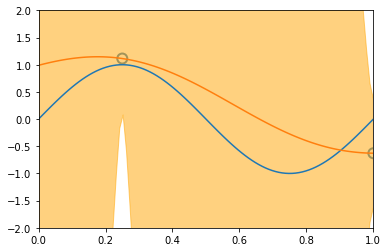

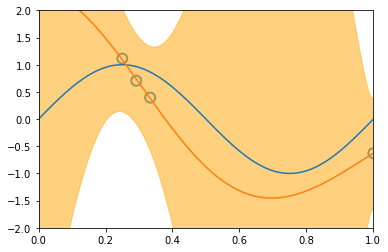

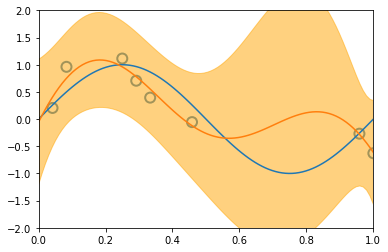

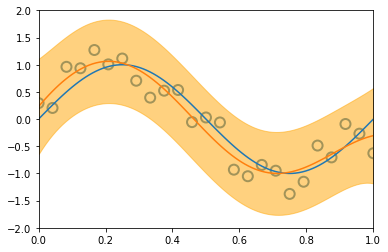

(100,)


In [13]:
# 自定义图3.8
x_train, y_train = create_toy_data(sinusoidal, 25, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = sinusoidal(x_test)

feature = GaussianFeature(np.linspace(0, 1, 9), 0.1)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

model = BayesianRegression(alpha=1e-3, beta=2.)

for begin, end in [[0, 1], [1, 2], [2, 4], [4, 8], [8, 25]]:
    model.fit(X_train[begin: end], y_train[begin: end])
    y, y_std = model.predict(X_test, return_std=True)
    plt.scatter(x_train[:end], y_train[:end], s=100, facecolor="none", edgecolor="steelblue", lw=2)
    plt.plot(x_test, y_test)
    plt.plot(x_test, y)
    plt.fill_between(x_test, y - y_std, y + y_std, color="orange", alpha=0.5)
    plt.xlim(0, 1)
    plt.ylim(-2, 2)
    plt.show()
print(y_std.shape)

图3.8中的图像只逐点以$ x $的函数的形式展示了预测方差。为了更加深刻地认识对于不同的$ x $值的预测之间的协方差，可以从$ w $的后验分布中抽取样本，然后画出对应的函数$ y(x, w) $，如图3.9所示：

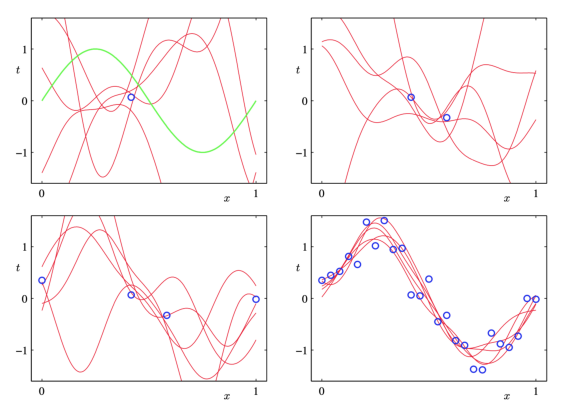

In [23]:
# 图3.9
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图3.9.png')
plt.axis('off')
ax.imshow(d)

如果我们使用**局部化的基函数（如高斯基函数），那么在距离基函数中心比较远的区域，预测方差（3.59）的第二项的贡献将会趋向于0，只剩下噪声贡献$ \beta^{−1} $。因此，模型认为对于处于基函数所在的区域之外的区域所做出的预测十分准**，这通常不是我们想要的结果。通过采用一种被称为**高斯过程**的另一种贝叶斯方法，可以避免这个问题。

注意，如果$ w, \beta $都被当成未知的，那么根据2.3.6节的讨论，我们可以引入一个由高斯-Gamma分布给出的共轭先验分布$ p(w, \beta) $(Denison et al., 2002)。在这种情况下，预测是一个学生t分布。



## 3.3.3 等价核

线性基函数模型的后验均值解（3.53）有一个很有趣的解释，它为核方法（包括高斯过程）提供了舞台。如果我们把式（3.53）代入式（3.3），那么预测均值就可以写成
$ y(x,m_N) = m_N^T\phi(x)=\beta\phi(x)^TS_N\Phi^Tt=\sum\limits_{n=1}^N\beta\phi(x)^TS_N\phi(x_n)t_n \tag{3.60} $


$$ y(x,w) = \sum\limits_{j=0}^{M-1}w_j\phi_j(x) = w^T\phi(x) \tag{3.3} $$

其中$ w = (w_0,...,w_{M-1})^T , \phi = (\phi_0,...,\phi_{M-1})^T $。

$ \begin{eqnarray} m_N &=& \beta S_N\Phi^Tt \tag{3.53} \end{eqnarray} $

其中
$$ \begin{eqnarray}\ S_N^{-1} &=& S_0^{-1} + \beta\Phi^T\Phi \tag{3.51} \end{eqnarray} $$
因此点$ x $处的预测分布是由训练集的目标变量$ t_n $的线性组合给出，可以写成
$ y(x,m_N) = \sum\limits_{n=1}^Nk(x,x_n)t_n \tag{3.61} $
其中函数
$ k(x,x') = \beta\phi(x)^TS_N\phi(x') \tag{3.62} $
被称为**平滑矩阵（smoother matrix）或等价核（equivalent kernel）**。像这样，**通过训练集的目标值的线性组合来进行预测的回归函数被称为线性平滑（linear smoother）**。注意，因为这些输入值$ x_n $出现在了$ S_N $的定义中，所以等价核依赖于来自数据集的输入值$ x_n $。图3.10展示了在高斯基函数下，三个不同的$ x $值的等价核核函数$ k(x,x') $与$ x' $的函数关系。

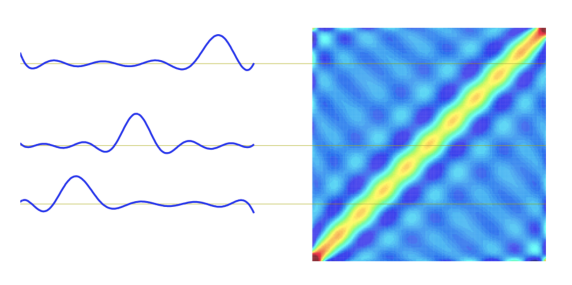

In [26]:
# 图3.10
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图3.10.png')
plt.axis('off')
ax.imshow(d)

我们看到，它们在局限在$ x $的周围，所以在$ x $处的预测分布的均值$ y(x,m_N) $可以通过对目标值加权组合的方式获得（**距离$ x $较近的数据点有较高的权值，而距离$ x $较远的数据点有较低的权值**）。直观来讲，赋予局部信息比远处信息更高的权值是很合理的。注意，就像图3.11展示的那样，这个局部性不仅对于局部的高斯基函数成立，对非局部的多项式基函数和sigmoid基函数也成立。

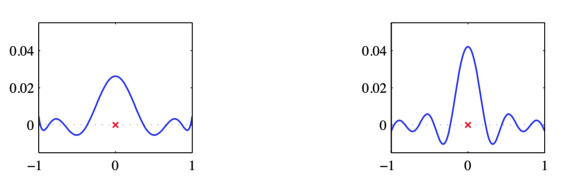

In [27]:
# 图3.11
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图3.11.png')
plt.axis('off')
ax.imshow(d)

考虑$ y(x),y(x') $间的协方差
$ \begin{eqnarray} cov[y(x),y(x')] &=& cov[\phi(x)^Tw,w^T\phi(x')] \ &=& \phi(x)^TS_N\phi(x') = \beta^{-1}k(x,x') \tag{3.63} \end{eqnarray} $

可以进一步了解等价核的作用。其中使用了式（3.49），（3.62）。从等价核的形式，我们可以得到预测的均值与附近的点高度相关，而与距离较远的点相关性较低。
$ p(w|t) = \mathcal{N}(w|m_N,S_N) \tag{3.49} $

$ k(x,x') = \beta\phi(x)^TS_N\phi(x') \tag{3.62} $

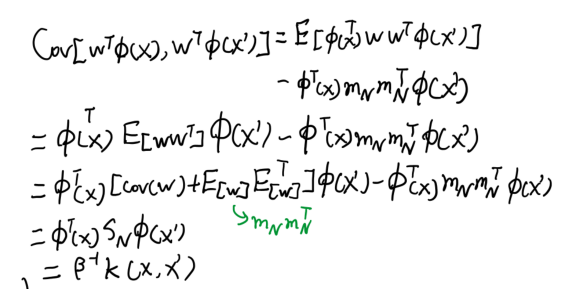

In [28]:
# 推导
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/推导.png')
plt.axis('off')
ax.imshow(d)

图3.8展示的预测分布允许我们逐点的可视化预测的由式（3.59）控制不确定性。然而，通过从$ w $的后验分布中抽取样本，再在图3.9中画出对应的模型函数$ y(x,w) $，我们可视化了$ y $值与两个（者更多）$ x $值后验概率分布中位处的之间的由等价核控制不确定性。

用核函数表示线性回归是解决回归问题的另一种方法。在给定观测数据集的条件下，**直接定义一个局部的核函数，而不是引入一组基函数来隐式地定义了一个等价的核**，然后使用这个核函数对新的输入变量$ x $做预测。这就是将在6.4节详细讨论的用于回归问题（以及分类问题）的一个称为高斯过程（Gaussian process）的实用框架。
我们已经看到，有效核定义了训练数据集里的目标值组合的权值，然后对新的$ x $值做预测。可以证明权值的和为1，即：
$ \sum\limits_{n=1}^Nk(x,x_n) = 1 \tag{3.64} $
对于所有$ x $成立。

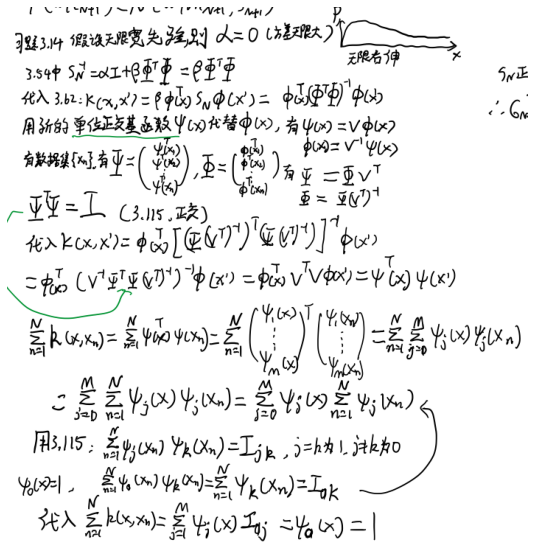

In [25]:
# 习题3.14
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/习题3.14.png')
plt.axis('off')
ax.imshow(d)

注意，这个求和**等价于对于所有的$ n $都有$ t_n = 1 $的目标数据集的预测均值$ \hat{y}(x) $**。**假设基函数是线性无关的，且数据点比基函数多，其中一个基函数是常数（对应偏置参数），很明显我们可以精确的拟合训练数据，因此预测均值就是简单的$ \hat{y}(x) = 1 $，这样就非形式化的证明了（3.64）这个直观上很漂亮的结果**。注意，核函数可以为负也可以为正，因此它虽然满足和限制，但是对应的预测未必是训练集目标值的凸组合。
最后，我们注意到等价核（3.62）满足一个与一般的核函数共有的要性质，即它可以表示为非线性函数的向量$ \psi(x) $的内积，即
$ k(x,z) = \psi(x)^T\psi(z) \tag{3.65} $
其中$ \psi(x) = \beta^{1/2}S_N^{1/2}\phi(x) $。



参考资料：
- https://math.stackexchange.com/questions/2796446/formula-of-prml3-63
- http://prml.yutorihiro.com
- https://twitter.com/d_nishiyama85/status/1013774141869051905/photo/1

## 3.5

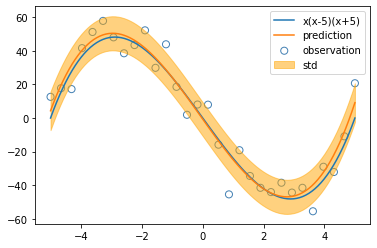

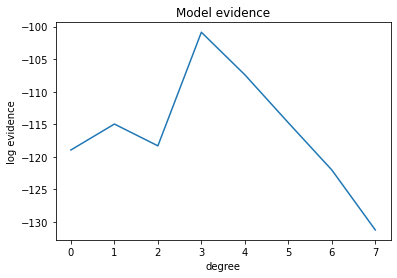

In [63]:
# 3.5
def cubic(x):
    return x * (x - 5) * (x + 5)

x_train, y_train = create_toy_data(cubic, 30, 10, [-5, 5])
x_test = np.linspace(-5, 5, 100)
evidences = []
models = []
for i in range(8):
    feature = PolynomialFeature(degree=i)
    X_train = feature.transform(x_train)
    model = EmpiricalBayesRegression(alpha=100., beta=100.)
    model.fit(X_train, y_train, max_iter=100)
    evidences.append(model.log_evidence(X_train, y_train))
    models.append(model)

degree = np.nanargmax(evidences)
regression = models[degree]

X_test = PolynomialFeature(degree=int(degree)).transform(x_test)
y, y_std = regression.predict(X_test, return_std=True)

plt.scatter(x_train, y_train, s=50, facecolor="none", edgecolor="steelblue", label="observation")
plt.plot(x_test, cubic(x_test), label="x(x-5)(x+5)")
plt.plot(x_test, y, label="prediction")
plt.fill_between(x_test, y - y_std, y + y_std, alpha=0.5, label="std", color="orange")
plt.legend()
plt.show()

plt.plot(evidences)
plt.title("Model evidence")
plt.xlabel("degree")
plt.ylabel("log evidence")
plt.show()